# Day 29 - population

Data
- Global Human Settlement Layer (download [here](https://ghsl.jrc.ec.europa.eu/download.php))
- London shapefile (via [London Datastore](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london))

In [2]:
import os
import configparser

import rasterio
from rasterio.mask import mask
from rasterio.plot import show

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.transforms as transforms

import matplotlib.pyplot as plt

In [3]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

In [4]:
# set custom fonts
plt.rcParams['font.family'] = ['Inter']
from matplotlib import font_manager
subtitle_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inconsolata-Medium.ttf')
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Inconsolata-Semibold.ttf')

# Data processing

## Load data

In [5]:
# Load population raster files
pop1990 = rasterio.open('GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19.tif', 'r')
pop2020 = rasterio.open('GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19.tif', 'r')

In [6]:
# Load London boundary and reproject
london = gpd.read_file(os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson'))
london = london.to_crs('World_Mollweide')
shapes = london["geometry"]

## Clip raster

Helpful tutorial on working with raster data [here](https://kodu.ut.ee/~kmoch/geopython2020/L5/raster.html#clipping-a-raster)

In [7]:
def clip_raster_file(raster_filename, shapes):
    # load raster
    rasterfile = rasterio.open(raster_filename + ".tif", 'r')

    # clip raster
    out_image, out_transform = mask(dataset=rasterfile, shapes=shapes, crop=True)
    out_meta = rasterfile.meta.copy()
    rasterfile.close()

    # update metadata
    out_meta.update({"driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform}) 
    
    # save as new file
    with rasterio.open(raster_filename + "_clipped.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [8]:
# clip files
clip_raster_file("GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19", shapes)
clip_raster_file("GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19", shapes)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -200.0, 'width': 64, 'height': 43, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1000.0, 0.0, -39000.0,
       0.0, -1000.0, 6050000.0), 'blockysize': 16, 'tiled': False, 'interleave': 'band'}


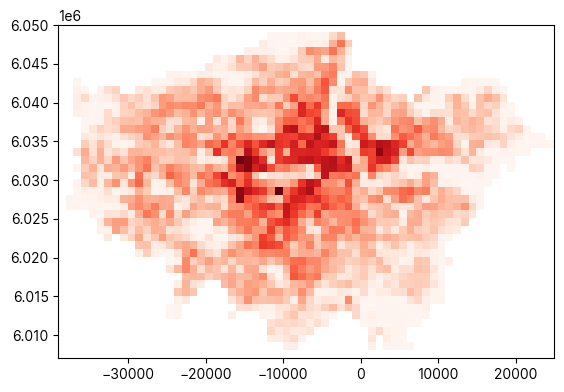

In [9]:
# quickly load and check
with rasterio.open('GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif', 'r') as data2:
    print(data2.profile)
    show(data2, cmap="Reds")

## Extract data

As per [this thread](https://gis.stackexchange.com/questions/394455/how-to-find-coordinates-of-pixels-of-a-geotiff-image-with-python)

In [10]:
# Load clipped population raster files
pop1990 = rasterio.open('GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif', 'r')
pop2020 = rasterio.open('GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif', 'r')

In [11]:
# extract coords and value from each pixel and store in dataframe
def extract_data_from_raster(openraster):
    values = openraster.read(1) # read band 1
    no_data = openraster.nodata
    data = [(openraster.xy(x,y)[0],openraster.xy(x,y)[1],values[x,y]) for x,y in np.ndindex(values.shape) if values[x,y] != no_data]
    lon = [i[0] for i in data]
    lat = [i[1] for i in data]
    d = [i[2] for i in data]
    df = pd.DataFrame({"lon":lon,'lat':lat,"data":d})
    return df

pop1990_df = extract_data_from_raster(pop1990).rename(columns={"data":"1990"})
pop2020_df = extract_data_from_raster(pop2020).rename(columns={"data":"2020"})

In [12]:
# alternative solution: Use rioxarray
#import rioxarray
#rds = rioxarray.open_rasterio('GHS_POP_E1990_GLOBE_R2023A_54009_1000_V1_0_R3_C19_clipped.tif')
#rds = rds.squeeze().drop("spatial_ref")
#rds.name = "data"
#res = rds.to_dataframe().reset_index()
#res

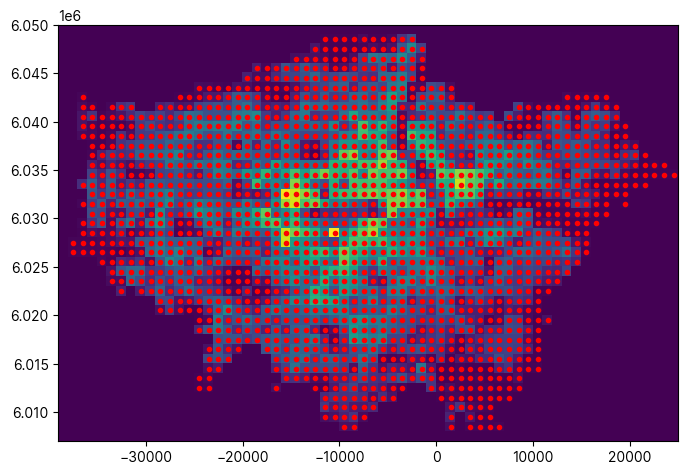

In [13]:
# check if looks correct
fig, ax = plt.subplots(figsize=(8, 8))
show(pop2020.read(1), transform=pop2020.transform,ax=ax)
ax.plot(pop2020_df.lon,pop2020_df.lat,'ro', markersize=3)

## Prepare for plotting

In [14]:
# merge data
df = pd.merge(pop1990_df, pop2020_df, on=["lon", "lat"])

# convert to geodataframe for correct projections
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'World_Mollweide', geometry = geometry)

# get percentage change
gdf["change"] = gdf["2020"] - gdf["1990"]
gdf["perc_change"] = (gdf["2020"] - gdf["1990"])/gdf["1990"] *100

# clean data and get absolute values
gdf.loc[gdf.index[np.isinf(gdf["perc_change"])], "perc_change"] = np.nan
gdf["perc_change_abs"] = abs(gdf["perc_change"] )
gdf["perc_change_dir"] = ["neg" if i <0 else "pos" for i in gdf["perc_change"]]

gdf

,lon,lat,1990,2020,geometry,change,perc_change,perc_change_abs,perc_change_dir
0,-11500.0,6048500.0,27.665820,28.644313,POINT (-11500.000 6048500.000),0.978492,3.536827,3.536827,pos
1,-10500.0,6048500.0,25.798586,39.844325,POINT (-10500.000 6048500.000),14.045739,54.443834,54.443834,pos
2,-9500.0,6048500.0,6.788011,9.028738,POINT (-9500.000 6048500.000),2.240727,33.010071,33.010071,pos
3,-8500.0,6048500.0,13.705713,25.493040,POINT (-8500.000 6048500.000),11.787327,86.003024,86.003024,pos
4,-7500.0,6048500.0,371.562328,516.068926,POINT (-7500.000 6048500.000),144.506597,38.891617,38.891617,pos
...,...,...,...,...,...,...,...,...,...
1587,1500.0,6008500.0,595.150742,692.816776,POINT (1500.000 6008500.000),97.666034,16.410302,16.410302,pos
1588,3500.0,6008500.0,82.374519,101.006965,POINT (3500.000 6008500.000),18.632447,22.619187,22.619187,pos
1589,4500.0,6008500.0,101.246118,130.715611,POINT (4500.000 6008500.000),29.469494,29.106789,29.106789,pos
1590,5500.0,6008500.0,53.228765,53.738102,POINT (5500.000 6008500.000),0.509337,0.956883,0.956883,pos


In [19]:
gdf[gdf["perc_change_dir"]=="neg"]

,lon,lat,1990,2020,geometry,change,perc_change,perc_change_abs,perc_change_dir
12,-10500.0,6047500.0,1.118208,1.087190,POINT (-10500.000 6047500.000),-0.031018,-2.773932,2.773932,neg
130,13500.0,6042500.0,330.216906,313.570299,POINT (13500.000 6042500.000),-16.646607,-5.041113,5.041113,neg
132,15500.0,6042500.0,99.504826,97.217732,POINT (15500.000 6042500.000),-2.287094,-2.298476,2.298476,neg
587,23500.0,6034500.0,24.366140,24.295255,POINT (23500.000 6034500.000),-0.070885,-0.290916,0.290916,neg
643,17500.0,6033500.0,28.108421,27.041498,POINT (17500.000 6033500.000),-1.066924,-3.795744,3.795744,neg
703,19500.0,6032500.0,2.321588,2.071678,POINT (19500.000 6032500.000),-0.249910,-10.764607,10.764607,neg
750,9500.0,6031500.0,406.789144,59.588253,POINT (9500.000 6031500.000),-347.200891,-85.351563,85.351563,neg
807,11500.0,6030500.0,87.441164,87.411673,POINT (11500.000 6030500.000),-0.029491,-0.033727,0.033727,neg
920,15500.0,6028500.0,1.113429,1.036200,POINT (15500.000 6028500.000),-0.077229,-6.936166,6.936166,neg
975,-37500.0,6026500.0,145.220005,142.806469,POINT (-37500.000 6026500.000),-2.413537,-1.661986,1.661986,neg


# Visualisation

In [16]:
# colors
pos_col = "#111111"
neg_col = "Red"
bg_col = "#f6f4ee"

In [17]:
# create custom legend
legend = {"x" :[0.9]*5,
          "y": [0.1, 0.15, 0.2, 0.25, 0.3],
          "s": [100, 50, 50, 100, 200], 
          "c": ["None" , "None", pos_col, pos_col, pos_col], 
          "lw": [1, 1, 0, 0, 0],
          "ec": [neg_col , neg_col , "None", "None", "None"],
          "l": ["-100", "-50", "50", "100", "200" ]
          }

In [41]:
# exclude areas with less than 50 people in 1990
gdf_filtered = gdf[(gdf["1990"]>99) | (gdf["2020"]>99) ].reset_index(drop=True)

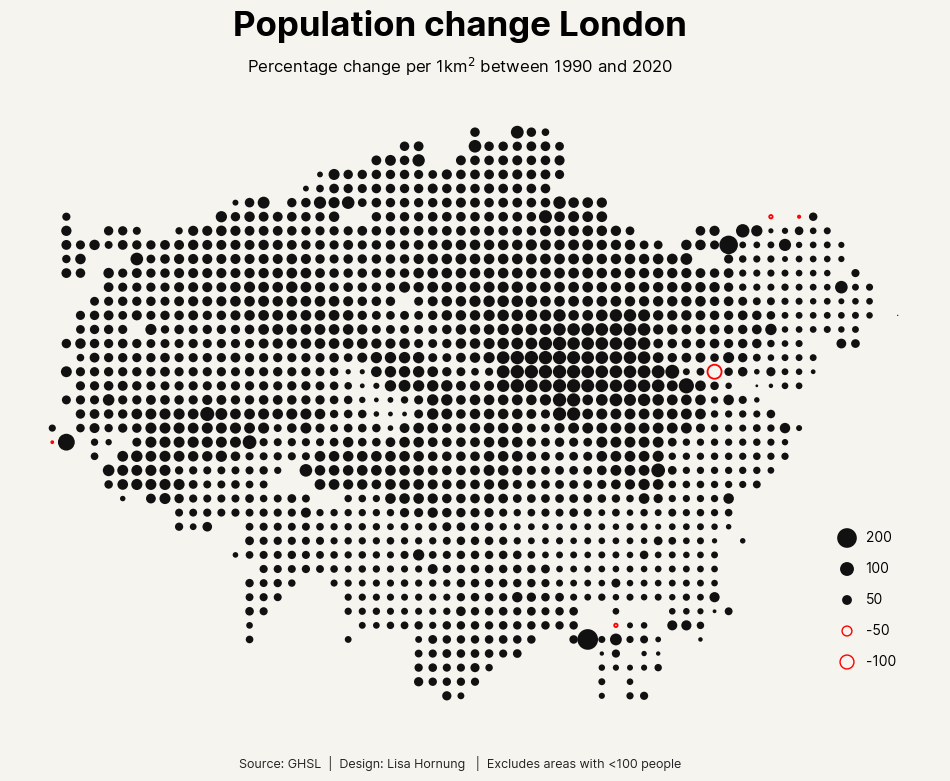

In [42]:
fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor(bg_col)

# plot data ---------------------
pos = gdf_filtered[gdf_filtered["perc_change"]>=0]
neg = gdf_filtered[gdf_filtered["perc_change"]<0]
pos.plot(ax=ax, markersize=pos["perc_change_abs"]*1.2,  color=pos_col,  linewidth=0, alpha=1)
neg.plot(ax=ax, markersize=neg["perc_change_abs"]*1.2,  color="None", edgecolor=neg_col , linewidth=1.3, alpha=1)
ax.axis("off")

# custom legend ---------------------
trans = transforms.blended_transform_factory(ax.transAxes, ax.transAxes)
ax.scatter(legend["x"],legend["y"], s=legend["s"], color=legend["c"], linewidth=legend["lw"], edgecolors=legend["ec"], transform=trans)
for i, text in enumerate(legend["l"]):
    ax.text(legend["x"][i]+0.02,legend["y"][i], text, transform=trans, ha="left", va="center")

# title and footer  ---------------------------
plt.figtext(0.5, 0.81 , "Population change London", fontsize=25,  fontweight="bold", ha='center')
plt.figtext(0.5, 0.78 , r'Percentage change per 1km$^2$ between 1990 and 2020',  fontsize=12,  ha='center')
plt.figtext(0.5, 0.2, 'Source: GHSL  |  Design: Lisa Hornung   |  Excludes areas with <100 people', fontsize=9, ha='center', color='#222222')

#save ----------------------
plt.savefig('london-population-change-over100.png', bbox_inches='tight', pad_inches=1, facecolor=bg_col, dpi=120)

plt.show()